In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import csv
import statsmodels.api as sm
from datetime import datetime
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from seaborn import histplot
import time
import joblib

### ***Read data***

In [2]:
df = pd.read_csv('../data/data_train_model.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.fillna(0, inplace=True)
df.head()

,high,low,open,unix,cum_change,sma_7_up,sma_7,sma_7_low,ema_14,b_ma,bu,bl,cma_7,month,atr,year,ppo,close
date,,,,,,,,,,,,,,,,,,
2020-01-02,209.789993,206.270004,206.750000,1577923200,0.045198,210.794776,209.779999,207.655221,209.779999,217.042583,227.120132,206.965034,211.514287,1,3.519989,2020,0.000000,209.779999
2020-01-03,210.399994,206.949997,207.210007,1578009600,0.090156,210.794776,209.224998,207.655221,209.631999,217.042583,227.120132,206.965034,211.514287,1,3.514990,2020,-0.042226,208.669998
2020-01-04,211.193329,206.806666,207.040003,1578096000,0.135397,210.888098,209.476666,208.065234,209.678399,217.042583,227.120132,206.965034,211.514287,1,3.577252,2020,-0.024991,209.980001
2020-01-05,211.986664,206.663335,206.870000,1578182400,0.180920,212.078555,209.930000,207.781446,209.893280,217.042583,227.120132,206.965034,211.514287,1,3.701972,2020,0.038602,211.290003
2020-01-06,212.779999,206.520004,206.699997,1578268800,0.226725,213.491436,210.464001,207.436567,210.254176,217.042583,227.120132,206.965034,211.514287,1,3.884688,2020,0.137642,212.600006


### ***Model Sarimax***

#### ***Split Data***

In [3]:
split_ratio = 0.8
cut_off = int(len(df) * split_ratio)
train_sarimax = df[:cut_off]
test_sarimax = df[cut_off:]
X_train_sarimax = train_sarimax.drop(['close'], axis=1)
X_test_sarimax = test_sarimax.drop(['close'], axis=1)
y_train_sarimax = train_sarimax['close']
y_test_sarimax = test_sarimax['close']

#### ***Check param***

In [4]:
model  = auto_arima(y=y_train_sarimax,
                    X=X_train_sarimax,
                    m = 7,
                    max_P=5,
                    max_Q=5,
                    seasonal=True,
                    test='adf',
                    alpha=0.05,              
                    d=None,                  
                    D=None,
                    error_action='ignore',
                    suppress_warnings=True, 
                    trace=True,
                    scoring='mse')
orders, seasonal_orders = model.order, model.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=5403.590, Time=3.05 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5517.234, Time=0.97 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5408.521, Time=2.34 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5416.246, Time=2.82 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13810.404, Time=0.97 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=5401.795, Time=2.85 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=5400.042, Time=1.95 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=5401.724, Time=2.63 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=5404.296, Time=1.95 sec


c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=5529.035, Time=1.73 sec
 ARIMA(3,0,2)(0,0,0)[7] intercept   : AIC=5400.988, Time=2.10 sec
 ARIMA(2,0,3)(0,0,0)[7] intercept   : AIC=5403.582, Time=2.02 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=5408.052, Time=1.75 sec
 ARIMA(1,0,3)(0,0,0)[7] intercept   : AIC=5401.255, Time=2.02 sec
 ARIMA(3,0,1)(0,0,0)[7] intercept   : AIC=5399.105, Time=1.90 sec
 ARIMA(3,0,1)(1,0,0)[7] intercept   : AIC=5400.991, Time=2.85 sec
 ARIMA(3,0,1)(0,0,1)[7] intercept   : AIC=5401.180, Time=2.74 sec
 ARIMA(3,0,1)(1,0,1)[7] intercept   : AIC=5402.976, Time=2.97 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=5397.210, Time=1.97 sec
 ARIMA(3,0,0)(1,0,0)[7] intercept   : AIC=5399.158, Time=3.13 sec
 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=5399.383, Time=2.59 sec
 ARIMA(3,0,0)(1,0,1)[7] intercept   : AIC=5401.174, Time=3.51 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=5407.325, Time=2.60 sec
 ARIMA(4,0,0)(0,0,0)[7] intercept   : AIC=5399.115, Time=3.04 sec
 ARIMA(4,0

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[7]             : AIC=5527.035, Time=1.81 sec
 ARIMA(4,0,1)(0,0,0)[7]             : AIC=5399.289, Time=2.12 sec

Best model:  ARIMA(3,0,0)(0,0,0)[7]          
Total fit time: 96.624 seconds


In [5]:
model_sarimax = SARIMAX(
            endog=y_train_sarimax,
            exog=X_train_sarimax,
            order=orders,
            seasonal_order=seasonal_orders,
            freq='D',
            trend=None,
            enforce_stationarity=False,
            enforce_invertibility=False,
            mle_regression=True
        )
model_fit = model_sarimax.fit(disp=0)
print("Model's AIC = {:.4f}".format(model_fit.aic))
print(model_fit.summary())

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Model's AIC = 5385.9485
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1338
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -2671.974
Date:                Thu, 05 Dec 2024   AIC                           5385.949
Time:                        23:43:15   BIC                           5495.079
Sample:                    01-02-2020   HQIC                          5426.841
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
high           0.7617   9.68e-05   7867.085      0.000       0.761       0.762
low            0.7700   9.57e-05   8043.440      0.000       0.770       0.770
open          -0.5945   9.67

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
forecasts = model_fit.predict(start=y_test_sarimax.index[0], end=y_test_sarimax.index[-1], exog=X_test_sarimax, dynamic=True)

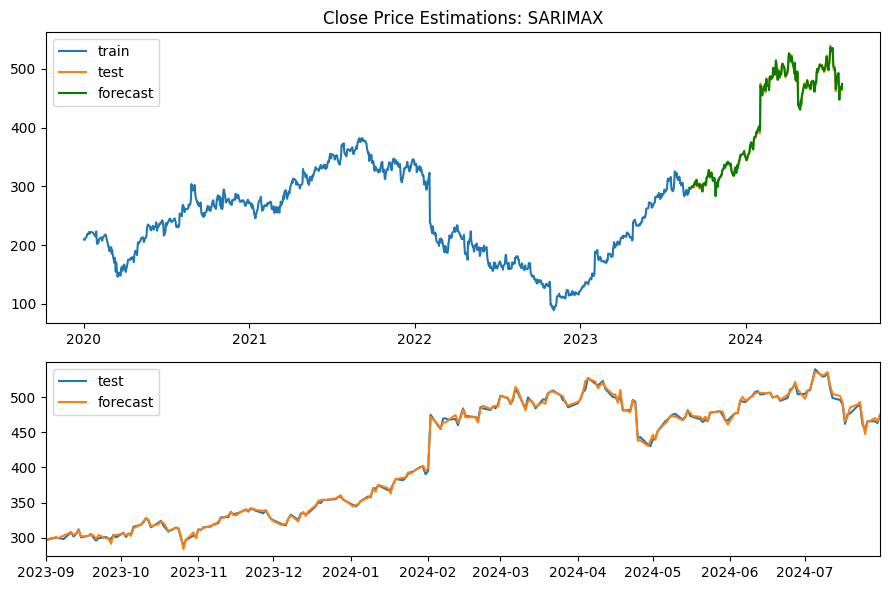

In [7]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(9, 6), tight_layout=True, gridspec_kw={'height_ratios': [1.5, 1]})
axes[0].plot(y_train_sarimax, label='train')
axes[0].plot(y_test_sarimax, linewidth=1.5, label='test')
axes[0].plot(forecasts, color='green', label='forecast')
axes[0].set_title('Close Price Estimations: SARIMAX')
axes[0].legend()

axes[1].plot(y_test_sarimax, linewidth=1.5, label='test')
axes[1].plot(forecasts, label='forecast')
axes[1].set_xlim(y_test_sarimax.index[0], y_test_sarimax.index[-1])
axes[1].set_ylim(min(y_test_sarimax.min(), forecasts.min()) - 10, max(y_test_sarimax.max(), forecasts.max()) + 10)
axes[1].legend()

In [8]:
def cross_val_sarimax(data, orders, seasonal_orders, k=6, test_data=True):
        '''
        Returns k-fold cross-validation score (RMSE).

        '''
        tscv = TimeSeriesSplit(n_splits=k)
        cv_scores = []
        
        for train_index, test_index in tscv.split(data):
            # set endogenous & exogenous variables
            cv_endog_train, cv_endog_test = data.iloc[train_index, -1:], data.iloc[test_index, -1:]
            cv_exog_train, cv_exog_test = data.iloc[train_index, :-1], data.iloc[test_index, :-1]
            
            mod = SARIMAX(
                endog=cv_endog_train,
                exog=cv_exog_train,
                order=orders,
                seasonal_order=seasonal_orders,
                freq='D',
                trend=None,
                enforce_stationarity=False,
                enforce_invertibility=False,
                mle_regression=True
            ).fit()
            
            # get scores & append to list
            forecasts = mod.predict(start=cv_endog_test.index[0], end=cv_endog_test.index[-1], exog=cv_exog_test, dynamic=True)
            rmse = np.sqrt(mean_squared_error(cv_endog_test, forecasts))
            cv_scores.append(rmse)
            
        return np.mean(cv_scores)

In [9]:
rmse = np.sqrt(mean_squared_error(y_test_sarimax, forecasts))
cv_rmse = cross_val_sarimax(df, orders, seasonal_orders)
r2 = r2_score(y_test_sarimax, forecasts)
mae = mean_absolute_error(y_test_sarimax, forecasts)
mape = mean_absolute_percentage_error(y_test_sarimax, forecasts)

c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DANG QUOC TOAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

In [10]:
print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
print('6-fold CV: {:.4f}'.format(cv_rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 2.7048
6-fold CV: 2.4136
R2: 0.9989
MAE: 2.0341
MAPE: 0.0049%


### ***Get residual Train model LSTM***

In [11]:
residual_train = model_fit.resid
df_residual_train = pd.DataFrame(residual_train, columns=['Residual Train'])
residual_test = y_test_sarimax - forecasts
df_residual_test = pd.DataFrame(residual_test, columns=['Residual Test'])

In [13]:
print("Shape Train Sarimax = ", train_sarimax.shape)
print("Shape Test Sarimax = ", test_sarimax.shape)
print("Shape residual train = ", residual_train.shape)
print("Shape residual test = ", residual_test.shape)

Shape Train Sarimax =  (1338, 18)
Shape Test Sarimax =  (335, 18)
Shape residual train =  (1338,)
Shape residual test =  (335,)


In [16]:
residual = pd.concat([residual_train, residual_test])

In [17]:
df['residual'] = residual
df.head()

,high,low,open,unix,cum_change,sma_7_up,sma_7,sma_7_low,ema_14,b_ma,bu,bl,cma_7,month,atr,year,ppo,close,residual
date,,,,,,,,,,,,,,,,,,,
2020-01-02,209.789993,206.270004,206.750000,1577923200,0.045198,210.794776,209.779999,207.655221,209.779999,217.042583,227.120132,206.965034,211.514287,1,3.519989,2020,0.000000,209.779999,2.895774e-09
2020-01-03,210.399994,206.949997,207.210007,1578009600,0.090156,210.794776,209.224998,207.655221,209.631999,217.042583,227.120132,206.965034,211.514287,1,3.514990,2020,-0.042226,208.669998,-1.349094e-01
2020-01-04,211.193329,206.806666,207.040003,1578096000,0.135397,210.888098,209.476666,208.065234,209.678399,217.042583,227.120132,206.965034,211.514287,1,3.577252,2020,-0.024991,209.980001,6.540895e-01
2020-01-05,211.986664,206.663335,206.870000,1578182400,0.180920,212.078555,209.930000,207.781446,209.893280,217.042583,227.120132,206.965034,211.514287,1,3.701972,2020,0.038602,211.290003,1.156300e+00
2020-01-06,212.779999,206.520004,206.699997,1578268800,0.226725,213.491436,210.464001,207.436567,210.254176,217.042583,227.120132,206.965034,211.514287,1,3.884688,2020,0.137642,212.600006,1.607862e+00


### ***Model Lstm***

In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model 

from keras.models import Sequential 
from keras.layers import LSTM 
from keras.layers import Dropout 
from keras.layers import Dense

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [19]:
df1 = pd.DataFrame(df,columns=['residual'])
df1 = df1.reset_index(drop=True)
df1 = df1.values

In [24]:
scaler = MinMaxScaler(feature_range=(0,1))
cut_off = int(len(df1) * split_ratio)
train = df1[:cut_off]
test = df1[cut_off:]
scaled_train = scaler.fit_transform(train)
print('Train shape:', scaled_train.shape)
scaled_test = scaler.fit_transform(test)
print('Test shape:', scaled_test.shape)

Train shape: (1338, 1)
Test shape: (335, 1)


In [25]:
x_train,y_train=[],[]
for i in range(30,len(scaled_train)):
  x_train.append(scaled_train[i-30:i,0]) 
  y_train.append(scaled_train[i,0])

In [26]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [27]:
x_test,y_test=[],[]
for i in range(30,len(scaled_test)):
  x_test.append(scaled_test[i-30:i,0]) 
  y_test.append(scaled_test[i,0])

In [28]:
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
y_test = np.reshape(y_test,(y_test.shape[0],1))

In [35]:
model = Sequential() 
model.add(LSTM(units=64,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
lstm_history = model.fit(x_train,y_train,epochs=50,batch_size=10,verbose=1,callbacks=None)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0527
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0105
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0116
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0121
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0117
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0126
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0099
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0124
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0103
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0106
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0111
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0108
Epoch 13/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0111
Epoch 14/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0120
Epoch 15/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s

In [51]:
lstm_predictions = model.predict(x_test)
residul_pre= scaler.inverse_transform(lstm_predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [52]:
residul_pre.shape

(305, 1)

In [53]:
print(forecasts.shape)
print(residul_pre.shape)

(335,)
(305, 1)


In [61]:
forecasts

2023-09-01    296.451025
2023-09-02    298.060407
2023-09-03    299.298263
2023-09-04    299.804800
2023-09-05    300.393652
                 ...    
2024-07-27    466.275000
2024-07-28    468.177373
2024-07-29    470.352216
2024-07-30    465.731072
2024-07-31    474.137413
Freq: D, Name: predicted_mean, Length: 335, dtype: float64

In [70]:
residul_pre_series = pd.Series(residul_pre.flatten(), index=forecasts.index[30:30+len(residul_pre)])

In [72]:
forecasts.iloc[30:] += residul_pre_series

In [73]:
forecasts

2023-09-01    296.451025
2023-09-02    298.060407
2023-09-03    299.298263
2023-09-04    299.804800
2023-09-05    300.393652
                 ...    
2024-07-27    463.887969
2024-07-28    465.818913
2024-07-29    467.967027
2024-07-30    463.261642
2024-07-31    471.548689
Freq: D, Name: predicted_mean, Length: 335, dtype: float64

In [74]:
rmse = np.sqrt(mean_squared_error(y_test_sarimax, forecasts))
# cv_rmse = cross_val_sarimax(data, orders, seasonal_orders)
r2 = r2_score(y_test_sarimax, forecasts)
mae = mean_absolute_error(y_test_sarimax, forecasts)
mape = mean_absolute_percentage_error(y_test_sarimax, forecasts)

In [75]:
print('Testing performance:')
print('--------------------')
print('RMSE: {:.4f}'.format(rmse))
# print('6-fold CV: {:.4f}'.format(cv_rmse))
print('R2: {:.4f}'.format(r2))
print('MAE: {:.4f}'.format(mae))
print('MAPE: {:.4f}%'.format(mape))

Testing performance:
--------------------
RMSE: 3.3067
R2: 0.9984
MAE: 2.6825
MAPE: 0.0065%
